Data Loading & Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import random

print("Libraries loaded successfully.")




Libraries loaded successfully.


In [2]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled = X_scaled[sample_indices]
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
964794,0.652871,1.005894,0.555821,0.568866,0.743947,1.604299
149099,0.399588,0.653769,-2.287419,-1.357419,1.888261,1.661142
415997,0.813335,0.661996,-1.355634,-0.429328,0.407384,0.524291
398571,0.581680,0.980536,-1.324483,-0.208175,0.542009,0.240079
539928,-1.268126,-1.768256,0.543073,-0.149630,0.945885,0.865346


K-Means

Elbow Method

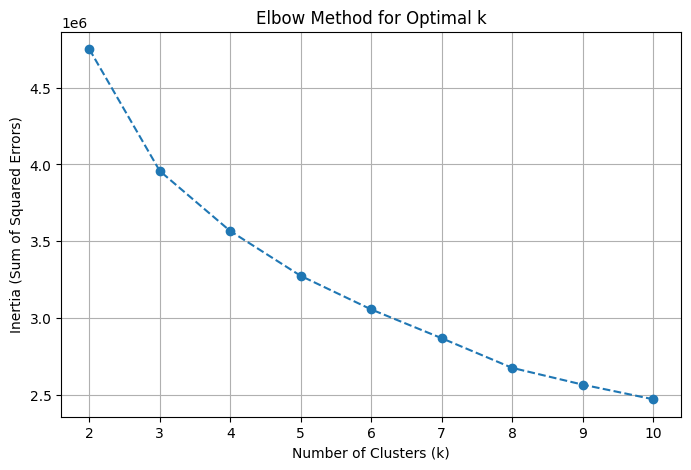

In [3]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

K-Means Algorithm Implementation

In [4]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids


Application

In [5]:
#I choose k based on the Elbow Plot 
k_optimal = 4
max_iters = 10

#Randomly pick k points from our sample to be the starting centroids
random_indices = np.random.choice(X_sample_scaled.shape[0], k_optimal, replace=False)
centroids = X_sample_scaled[random_indices]

assignments = np.zeros(X_sample_scaled.shape[0])

print(f"\nStarting Manual K-Means Algorithm (k={k_optimal})...")

#K means
for i in range(max_iters):
    print(f"Iteration {i+1}/{max_iters}...")
    
    #Assign points to clusters 
    assignments = find_closest_centroids(X_sample_scaled, centroids)
    
    #Calculate new centroids
    previous_centroids = centroids
    centroids = compute_centroids(X_sample_scaled, assignments, k_optimal)
    
    #Check for convergence (if centroids don't change, we stop)
    if np.all(centroids == previous_centroids):
        print("Converged early!")
        break

print("Manual Clustering Completed Successfully.")


Starting Manual K-Means Algorithm (k=4)...
Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...
Manual Clustering Completed Successfully.


Visualization and analysis

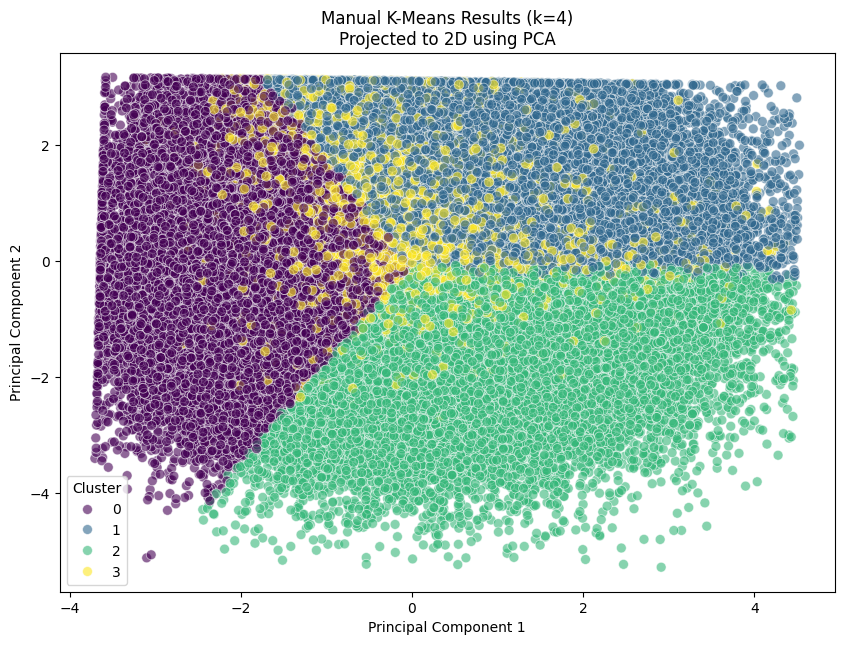


--- Cluster Profiles (Average Values) ---
            BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore
Cluster                                                                    
0        8.681658e+05         2.010461e+06    6.408928            63.813582
1        1.631821e+07         4.589567e+07    7.767370            79.859050
2        1.501011e+07         4.183925e+07    5.052050            47.448327
3        6.181615e+06         1.639537e+07    6.907093            69.796649

Movies per Cluster:
 Cluster  NumMovies
       0      55767
       2      54110
       1      52522
       3      37600


In [6]:
#VISUALIZATION (PCA 2D)
#We use PCA only to project the 6-dimensional data onto a 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=assignments, 
    palette='viridis', 
    s=50, 
    alpha=0.6
)
plt.title(f'Manual K-Means Results (k={k_optimal})\nProjected to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#CLUSTER PROFILING
#Add the cluster labels to our sample dataframe
df_sample['Cluster'] = assignments

#Calculate the mean of the original features for each cluster
# Note: We use the original columns (before scaling) to make it readable (e.g. real dollars)
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster')[numeric_cols].mean()

print("\n--- Cluster Profiles (Average Values) ---")
print(profile)

#how many movies are in each cluster
print("\nMovies per Cluster:")
df_counts = df_sample['Cluster'].value_counts().reset_index()
df_counts.columns = ['Cluster', 'NumMovies']
print(df_counts.to_string(index=False))



DBSCAN

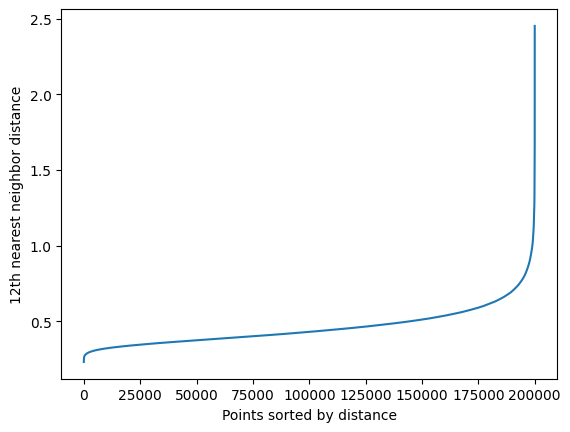

In [7]:
#We plot knn to try to choose an apropriate value for epsilon
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(X_sample_scaled_df)
distances, indices = neighbors_fit.kneighbors(X_sample_scaled_df)
distances = np.sort(distances[:, 11])
plt.plot(distances)
plt.ylabel("12th nearest neighbor distance")
plt.xlabel("Points sorted by distance")
plt.show()

In [8]:
clusterer = DBSCAN(eps=0.7, min_samples=12, metric='euclidean')
y_pred = clusterer.fit_predict(X_sample_scaled_df)

In [9]:
# Number of clusters and noise
unique_labels = np.unique(y_pred)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(y_pred).count(-1)  # O np.sum(y_pred == -1)

print(f"Número de clústers: {n_clusters}")
print(f"Número de puntos de ruido: {n_noise}")
print(f"Etiquetas únicas de clústers: {unique_labels[unique_labels != -1]}")  # Excluye -1

# We asign clusters in the DataFrame to see the details
df_sample['Cluster'] = y_pred
print("\nTamaños de cada clúster (incluyendo ruido como -1):")
print(df_sample.groupby('Cluster').size())

# Example: first 10 movies in each cluster
for cluster_id in unique_labels:
    if cluster_id != -1:
        print(f"\nClúster {cluster_id}:")
        print(df_sample[df_sample['Cluster'] == cluster_id][['Title', 'Genre', 'IMDbRating']].head(10))

Número de clústers: 1
Número de puntos de ruido: 3016
Etiquetas únicas de clústers: [0]

Tamaños de cada clúster (incluyendo ruido como -1):
Cluster
-1      3016
 0    196983
dtype: int64

Clúster 0:
                                 Title    Genre  IMDbRating
964794      Interesting or matter wind   Horror         7.6
149099                Career work role   Action         9.3
415997                        Guy also    Drama         7.1
398571         Foot reach response the   Comedy         7.3
539928              Understand without   Comedy         7.9
602851  Ready successful office detail  Romance         7.3
773804      Perform attorney direction   Horror         9.6
885885    Admit either evening because  Romance         6.9
732191                       Candidate    Drama         5.1
444269                  Message before    Drama         5.7


DBSCAN - Model Evaluation

In [10]:
# Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

# Silhouette Score
def compute_silhouette(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        print("No se puede calcular Silhouette: solo hay 1 clúster válido después de eliminar ruido.")
        return None
    return silhouette_score(X_scaled[mask], labels[mask])

# Davies-Bouldin
def compute_davies_bouldin(X_scaled, labels):
    # Davies-Bouldin requiere al menos 2 clusters reales
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Davies-Bouldin: solo hay 1 clúster.")
        return None
    return davies_bouldin_score(X_scaled, labels)

# Calinski-Harabasz
def compute_calinski_harabasz(X_scaled, labels):
    # Calinski-Harabasz también requiere al menos 2 clusters
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Calinski-Harabasz: solo hay 1 clúster.")
        return None
    return calinski_harabasz_score(X_scaled, labels)

# Execution

print("DBSCAN evaluation")
print("-----------------------------------")

# 1) Hopkins
H = hopkins(X_sample_scaled)
print(f"Hopkins Statistic: {H:.8f}")

# 2) Silhouette
sil = compute_silhouette(X_sample_scaled_df.values, y_pred)
print(f"Silhouette Score: {sil}")

# 3) Davies-Bouldin
dbi = compute_davies_bouldin(X_sample_scaled_df.values, y_pred)
print(f"Davies-Bouldin Index: {dbi}")

# 4) Calinski-Harabasz
chi = compute_calinski_harabasz(X_sample_scaled_df.values, y_pred)
print(f"Calinski-Harabasz Index: {chi}")


DBSCAN evaluation
-----------------------------------
Hopkins Statistic: 0.99998030
No se puede calcular Silhouette: solo hay 1 clúster válido después de eliminar ruido.
Silhouette Score: None
Davies-Bouldin Index: 3.923687970691183
Calinski-Harabasz Index: 1280.265896798221
